# Notes:

* fuck I lost my notes argh

* we have to multiply density, $f(x)$ by some interval $dx$ because the probability of getting an exact value is vanishingly small
* we are essentially summing up a bunch of small distributions about each data point to create an overall distribution
* KDE is useful for estimating data points that may not be in the data set


In [35]:
using CSV
using DataFrames
using PyPlot
using ScikitLearn
using Statistics
using Random
using LaTeXStrings
using Printf

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("bmh")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16;

In [13]:
df = CSV.read("apples.csv", copycols=true)
first(df, 6)

,mass
,Float64
1,108.205
2,92.1145
3,107.959
4,58.8771
5,100.104
6,67.4432


# Histograms aren't great for estimating densities
* data is jagged/discontinuous
* apparent density depends on bin size and location
* qualitative features in underlying data generating distribution can be hidden depending on how bins are chosen, including small shifts in bins even if they are the same width
* as dimensionality increases, the # of bins grow exponentially and most will end up empty in a higher dimensional histogram in the absence of a shitload of data

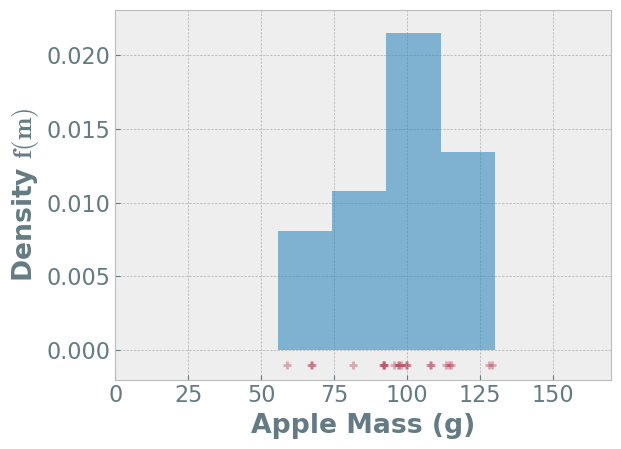

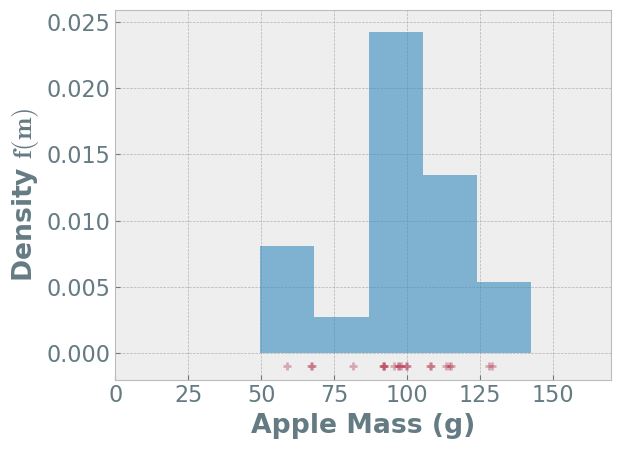

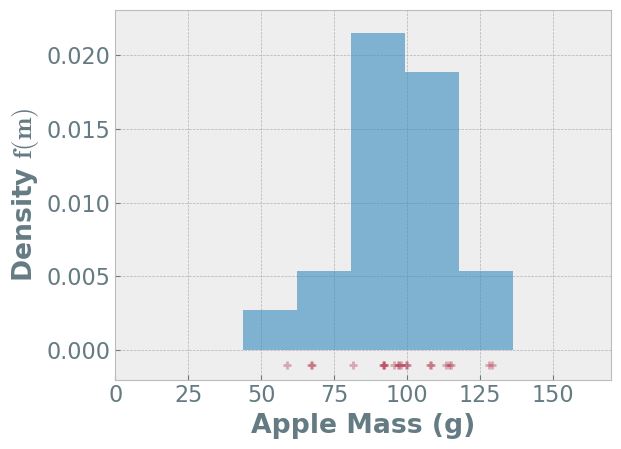

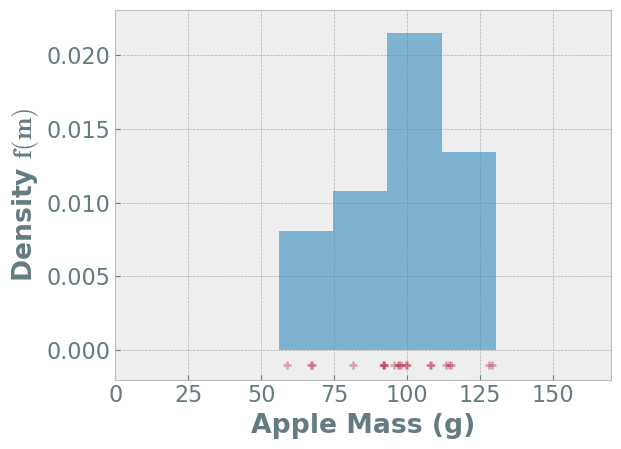

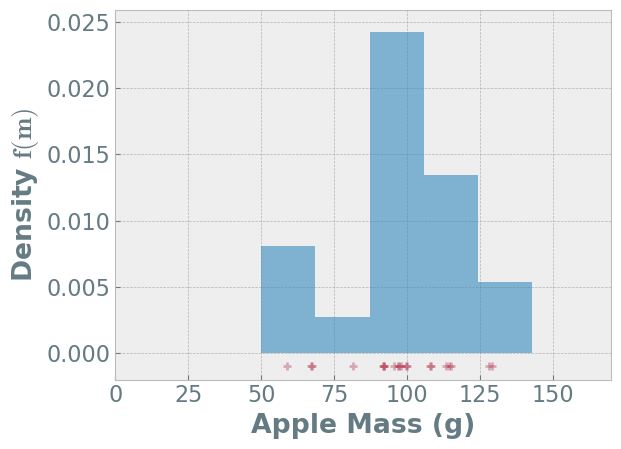

In [37]:
bins = range(0.0, stop=130, length=8)
offsets = range(0.0, 50.0, length=5)
for offset in offsets
    figure()
    xlabel("Apple Mass (g)", weight="bold")
    scatter(df[!, :mass], [-0.001 for _ = 1:nrow(df)], marker="+", alpha=0.3, color="C1")
    hist(df[!, :mass], alpha=0.6, bins=bins.+offset, normed=true)
    xlim([0, 170])
    ylim([-0.002, maximum(ylim())])
    ylabel(L"Density $\mathbf{f(m)}$", weight="bold")
end

## kernel functions
$\hat{f}(x) = \frac{1}{n}\sum^{n}_{i=1}K_{\lambda}(m,m_{i})$

This is KDE

A kernel function $K_{\lambda}(m, m_{i})$ is a weighting function that assigns a weight to $m_{i}$ based on its distance from $m$. Kernel functions are typically indexed by $\lambda$, the mandwidth that determines the neighborhood around $m$ where the kernel for $m_{i}$ is sizeable. There are many different kernel functions, but they all have the following conditions:

* symmetry $K(m, m_{i}) = K(m_{i}, m)$
* non-negative: $K(m, m_{i}) > 0$
* sums to 1: $\int_{-\infty}^{\infty} K(m_{i}, m)dm = 1$
* decays as $m_{i}$ gets farther from $m$: $\lim_{m_{i} \rightarrow \pm \infty} K(m_,m_{i}) = 0$
* kernel represents density contribution from $m_{i}$ on $m$

Gaussian density kernel:
$K_{\lambda}(m, m_{i}) = \frac{1}{\sqrt{2 \pi \lambda^{2}}}e^{-\frac{(m-m_{i})^{2}}{2\lambda^{2}}}$

In [62]:
"""
Gaussian kernel

Parameters
----------
m : Float64
    mass at which we want to estimate the density
m_i : Float64
    mass of an observed apple in our data set
λ : Float64
    bandwidth of our kernel

Returns
-------
K : Float64
    kernel density estimate at m
"""
function K(m::Float64, m_i::Float64, λ::Float64)
    return 1 / sqrt(2 * π * λ^2) * exp(-(m-m_i)^2 / (2 * λ^2))
end

λ = 2.0
@assert K(1.0, 1.0, λ) == 1 / sqrt(2 * π * λ^2)

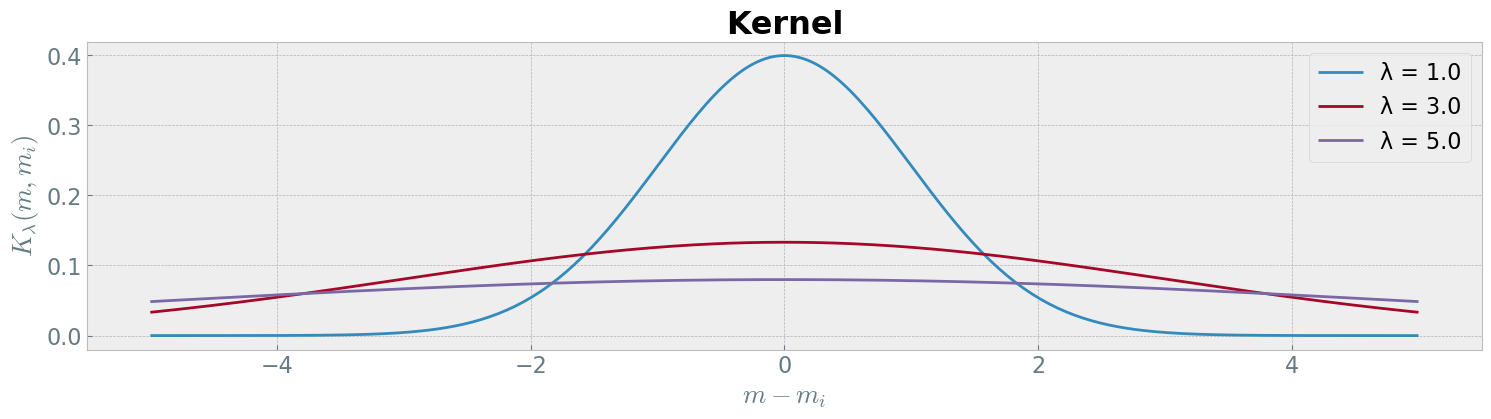

PyObject <matplotlib.legend.Legend object at 0x7f19e7749748>

In [76]:
fig, ax = subplots(1, 1, figsize=(18, 4))
m_minus_m_is = collect(range(-5.0, stop=5.0, length=300))
λs = [1.0, 3.0, 5.0]

ax.set_xlabel(L"$m - m_{i}$")
ax.set_ylabel(L"$K_{\lambda}(m, m_{i})$")
ax.set_title("Kernel", weight="bold")
for λ in λs
    k_λ = [K(0.0, Float64(m_minus_m_i), λ) for m_minus_m_i in m_minus_m_is]
    ax.plot(m_minus_m_is, k_λ, label="λ = $λ")
end
ax.legend()

In [71]:
function our_kde(m::Float64, sample_masses::Array{Float64}, λ::Float64)
    return sum([K(m, m_i, λ) for m_i in sample_masses]) / length(sample_masses)
end

our_kde(100.0, df[!, :mass], 2.0)

0.033037681149935286

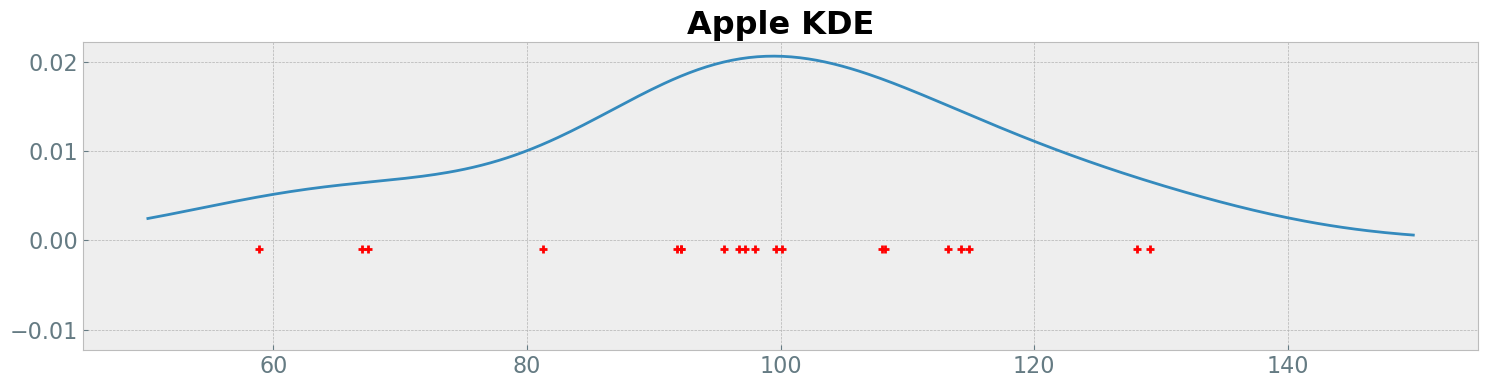

PyObject Text(0.5, 1.0, 'Apple KDE')

In [79]:
fig, ax = subplots(1, 1, figsize=(18, 4))
ax.scatter(df[!, :mass], [-0.001 for _ in 1:nrow(df)], marker="+", color="r")
λ = ((4 * std(df[!, :mass])^5) / (3 * nrow(df)))^(1/5)
ms = range(50.0, stop=150.0, length=300)
ρs = [our_kde(m, df[!, :mass], λ) for m in ms]
ax.plot(ms, ρs)
ax.set_title("Apple KDE", weight="bold")

## Tuning parameters for kde:
1. which kernel you use (least important)
2. bandwidth, $\lambda$, which shouldn't just be eyeballed

### Rules for $\lambda$ selection
#### Silverman's rule
$\lambda = (4 \sigma ^{5} / (3n))^(1/5)$
#### some other dude's rule
I guess we'll cover this later

What is the probability that, if we select an apple, its mass will be less than 80 g?

Monte carlo integration:
$P (M < 80) \approx (\frac{1}{80}\int^{80}_{0}\hat{f}(m)dm)80 = 80 <\hat{f}(m)dm> _{[0, 80]}$

In [87]:
ms = range(0, stop=80, length=10000)
ρs = [our_kde(m, df[!, :mass], λ) for m in ms]
sum(ρs) * diff(ms)[1]

mean(ρs) * 80


0.19603910474170014